In [1]:
import os
import pandas as pd
import rioxarray as riox
import glob
import datetime
import re
from tqdm import tqdm
import xarray as xr
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
agdd_DIR = "/90daydata/cper_neon_aop/npn/agdd/"

In [3]:
df_fq = pd.read_csv('../data/training/cper_pasture_2000_2024_fq_predictions.csv', parse_dates=['date'])

In [4]:
gdf_cper = gpd.read_file('../data/ground/boundaries/cper_pastures_2022_w_exclosures_spk.shp')

In [5]:
agdd_paths = glob.glob(os.path.join(agdd_DIR, '*.tif'))

In [8]:
xr_list = []
for f in tqdm(agdd_paths):
    xr_tmp = riox.open_rasterio(f)
    date_suffix = re.sub('.tif', '', os.path.basename(f).split('_')[-1])
    date_tmp = datetime.datetime(int(date_suffix[:4]), int(date_suffix[4:6]), int(date_suffix[6:]))
    xr_tmp = xr_tmp.squeeze().drop('band')
    xr_tmp = xr_tmp.assign_coords(date=date_tmp)
    xr_tmp = xr_tmp.expand_dims('date')
    #xr_tmp = xr_tmp.rio.reproject(32613)
    xr_list.append(xr_tmp)

100%|██████████| 1790/1790 [02:51<00:00, 10.44it/s]


In [9]:
xr_agdd = xr.concat(xr_list, dim='date').sortby('date')

In [10]:
from rasterio.plot import show

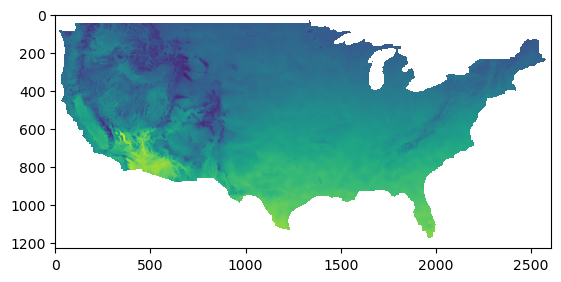

<AxesSubplot:>

In [11]:
show(xr_agdd.isel(date=200))

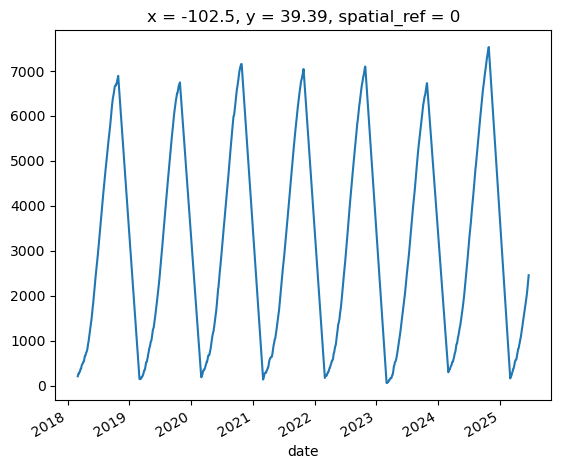

In [12]:
xr_agdd.isel(x=1000, y=500).plot()

In [ ]:
#xr_agdd_utm = xr_agdd.rio.reproject(32613)

In [13]:
bbox = gdf_cper.to_crs(xr_agdd.rio.crs).total_bounds

In [17]:
cper_agdd = xr_agdd.sel(x=slice(bbox[0], bbox[2]), 
                            y=slice(bbox[3], bbox[1])).mean(
    dim=['y', 'x']).drop(['spatial_ref']).to_dataframe(name='AGDD')

In [20]:
df_fq = pd.merge(df_fq, cper_agdd, how='left', on='date')

In [34]:
#df_fq

In [54]:
df_plot = df_fq[df_fq['Pasture'].isin(['23E', '23W', '15E']) & 
(df_fq['iNDVI_dry_pct'] > 0.15) &
df_fq['AGDD'].notnull()].groupby(
    ['Pasture', 'Year']).first().reset_index()

In [55]:
#df_plot

<AxesSubplot:xlabel='Pasture', ylabel='AGDD'>

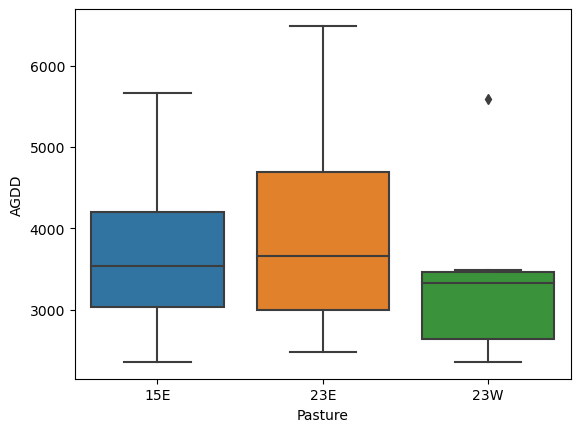

In [56]:
sns.boxplot(y='AGDD', x='Pasture', data=df_plot)

In [82]:
df_fq['NDVI_rel_max'] = df_fq.groupby(['Pasture', 'Year']).apply(lambda x: x['NDVI'] / x['NDVI'].max()).values
df_fq['CP_rel_max'] = df_fq.groupby(['Pasture', 'Year']).apply(lambda x: x['CP_pred'] / x['CP_pred'].max()).values
df_fq['DOM_rel_max'] = df_fq.groupby(['Pasture', 'Year']).apply(lambda x: x['DOM_pred'] / x['DOM_pred'].max()).values

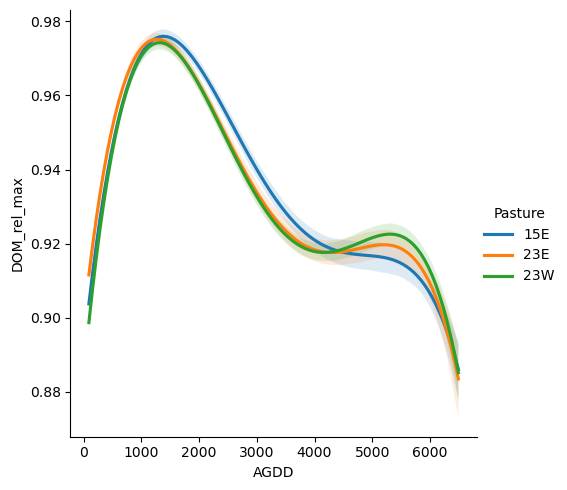

In [90]:
sns.lmplot(x='AGDD', y='DOM_rel_max', hue='Pasture', order=4, scatter=False,
            data=df_fq[
           df_fq['Pasture'].isin(['23E', '23W', '15E']) &
           df_fq['AGDD'].notnull()# &
          # df_fq['Year'].isin([2018, 2019, 2021, 2023, 2024])
           ])

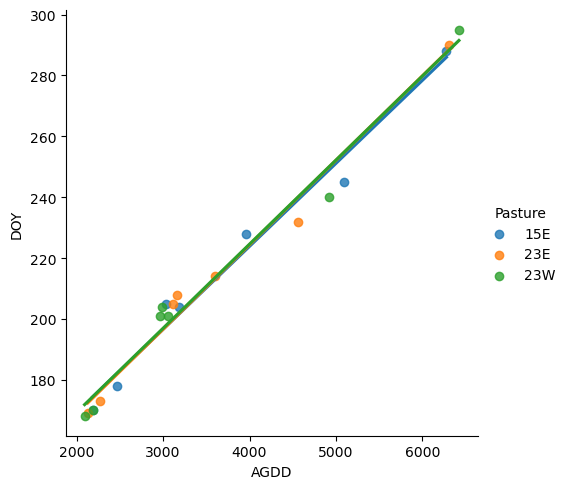

In [40]:
sns.lmplot(x='AGDD', y='DOY', hue='Pasture', ci=None,
          data=df_plot)

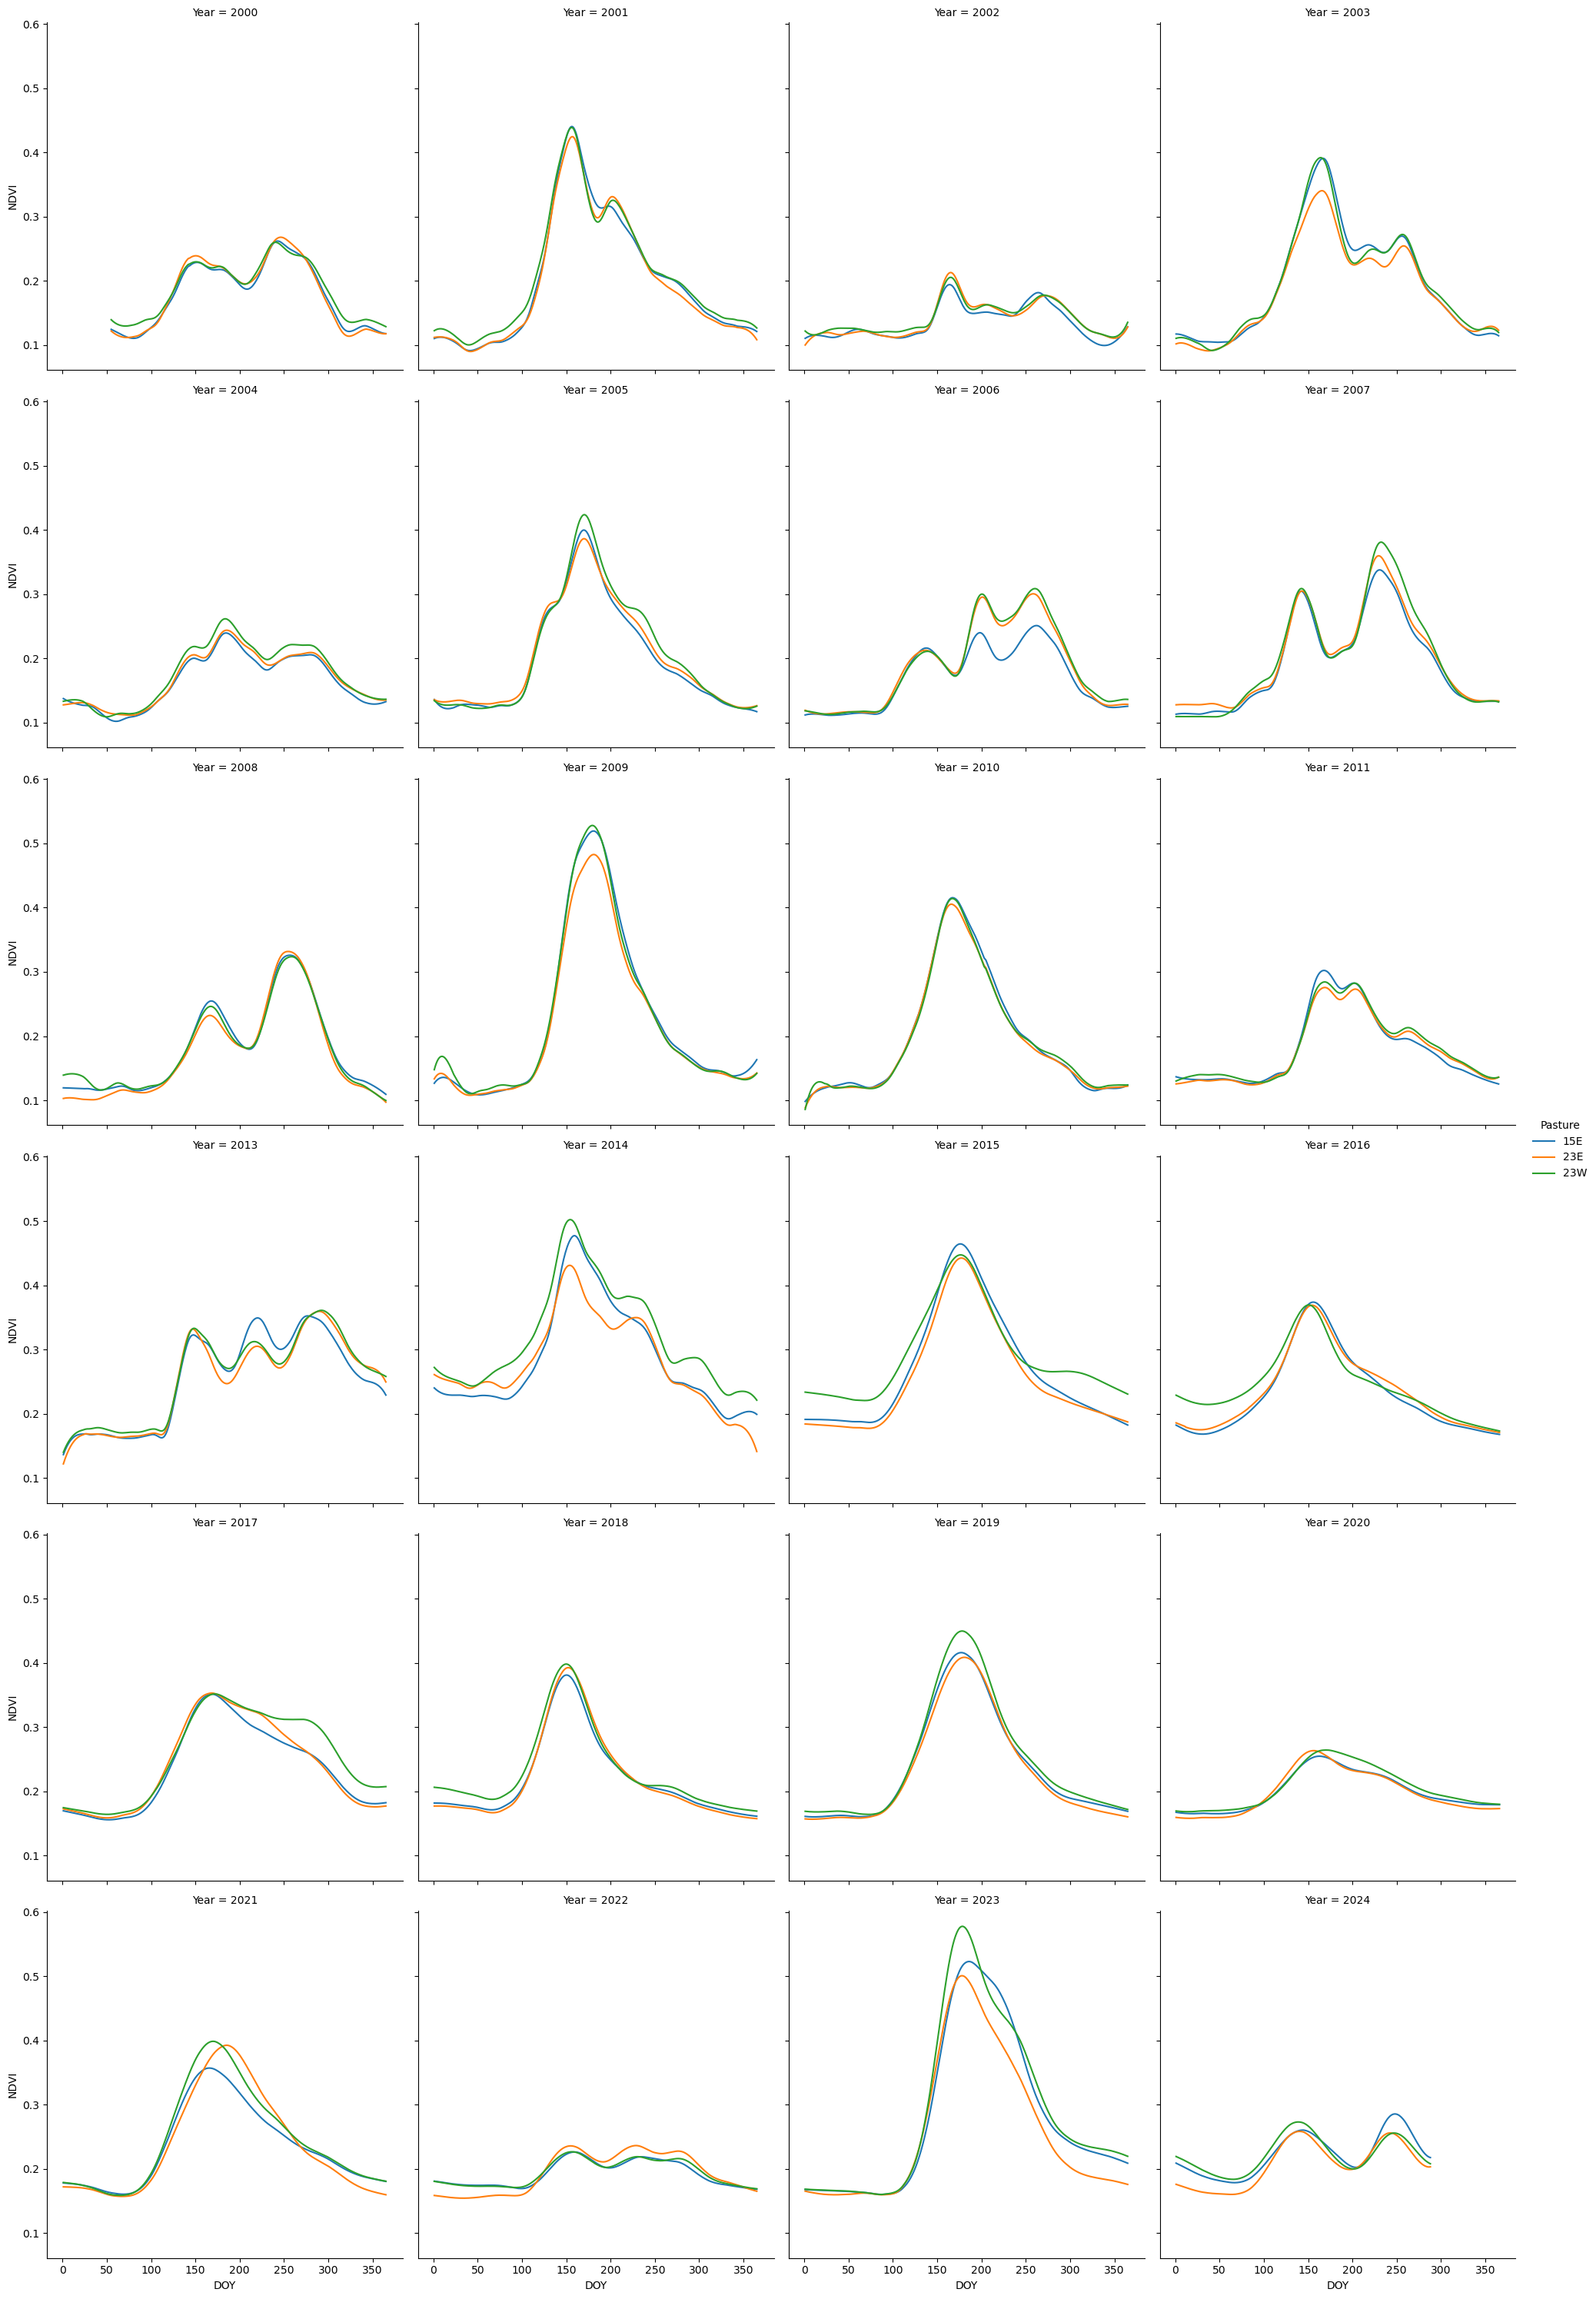

In [28]:
sns.relplot(kind='line', x='DOY', y='NDVI', hue='Pasture', col='Year', col_wrap=4,
            data=df_fq[df_fq['Pasture'].isin(['23E', '23W', '15E'])])

In [73]:
df_fq[df_fq['Pasture'].isin(['23E', '23W', '15E']) & (df_fq['Year'] == 2023)]

,Pasture,Year,NDVI,NDVI_d30,t_peak_IRG,iNDVI,iNDVI_dry,NDVI_rate,iNDVI_dry_pct,SOS_doy,t_SOS,date,CP_pred,DOM_pred,DOY
25253,15E,2023,0.167845,0.000000,-151,0.000000,0.000000,0.000000,0.000000,95,-95,2023-01-01,9.4100,62.683200,1
25254,15E,2023,0.167756,0.000000,-150,0.000000,0.000000,0.000000,0.000000,95,-94,2023-01-02,9.4100,62.683200,2
25255,15E,2023,0.167672,0.000000,-149,0.000000,0.000000,0.000000,0.000000,95,-93,2023-01-03,9.4100,62.683200,3
25256,15E,2023,0.167593,0.000000,-148,0.000000,0.000000,0.000000,0.000000,95,-92,2023-01-04,9.4100,62.683200,4
25257,15E,2023,0.167518,0.000000,-147,0.000000,0.000000,0.000000,0.000000,95,-91,2023-01-05,9.4100,62.683200,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107617,23W,2023,0.221859,-0.010016,215,46.081726,19.386763,0.171308,0.420704,92,268,2023-12-27,5.3724,62.428333,361
107618,23W,2023,0.221326,-0.010315,216,46.137528,19.428270,0.170880,0.421095,92,269,2023-12-28,5.3724,62.428333,362
107619,23W,2023,0.220782,-0.010627,217,46.192787,19.470786,0.170453,0.421511,92,270,2023-12-29,5.3724,62.441733,363
107620,23W,2023,0.220227,-0.010947,218,46.247490,19.514283,0.170028,0.421953,92,271,2023-12-30,5.3724,62.446133,364


In [78]:
gdf_cper[gdf_cper['Past_Name_'].isin(['15E', '23E', '23W'])]

,OBJECTID,Join_Count,TARGET_FID,Past_Name_,Ownership,Treatment,Shape_Leng,Shape_Area,NewStdyOpn,CARM_Name,CARM_Trtmt,CARM_Pair,geometry
16,18,0,17,23W,ARS_owned_operated,None,4772.537039,1.272869e+06,None,None,None,None,"POLYGON ((521671.125 4519545.500, 521670.531 4..."
25,28,1,27,15E,ARS_owned_operated,TGM,4884.100071,1.330634e+02,None,15E,TRM,10S,"POLYGON ((520814.547 4519548.500, 520586.625 4..."
60,70,0,69,23E,ARS_owned_operated,None,4724.510664,1.240823e+06,None,None,None,None,"POLYGON ((522393.052 4519546.846, 522395.652 4..."
